# Library Import

In [2]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

# Configuration Reading from File

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
name = 'tm_mesons_run3.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

200.0

In [8]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

200

In [9]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [10]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(200, 3, 32, 100)


## preliminary plots

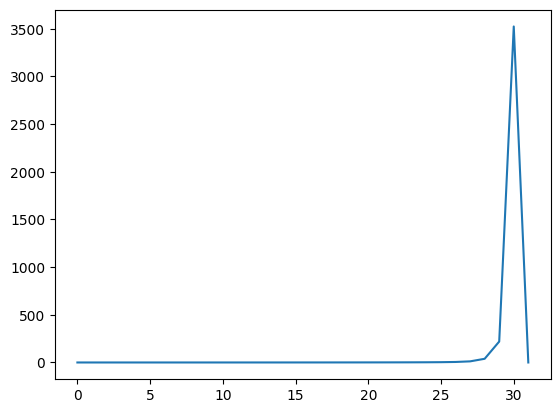

In [29]:
times = np.arange(tvals)
plt.plot(times,correlators[0,0,:,1])

# Jackknife Analysis

In [36]:
#noise average
correlators_navg = np.mean(correlators,axis=-1)

if verbose:
    print("(nconf,ncorr,tvals)")
    print(np.shape(correlators_navg))

(nconf,ncorr,tvals)
(200, 3, 32)


In [38]:
#creation of replicates
replicates = np.asarray( [ np.delete(correlators_navg,iconf,axis=0).mean(axis=0)  for iconf in range(nconf)] )

if verbose:
    print("(nreplicates,ncorr,tvals)")
    print(np.shape(replicates))

(nreplicates,ncorr,tvals)
(200, 3, 32)


In [48]:
jack_mean = np.mean(replicates,axis=0)
jack_std_re =  np.sqrt(  ( (nconf-1)/nconf ) * np.sum( (replicates.real - jack_mean.real)**2 , axis=0 ) )
jack_std_im =  np.sqrt(  ( (nconf-1)/nconf ) * np.sum( (replicates.imag - jack_mean.imag)**2 , axis=0 ) )

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(jack_mean))
    print(np.shape(jack_std))

(ncorr,tvals)
(3, 32)
(3, 32)


In [52]:
#relative std
jack_std_re/jack_mean.real

/tmp/ipykernel_16565/475753815.py:1: RuntimeWarning: invalid value encountered in divide
  jack_std_re/jack_mean.real


array([[            nan,  2.79675207e-03,  2.79675128e-03,
         2.79674976e-03,  2.79674702e-03,  2.79674218e-03,
         2.79673361e-03,  2.79671848e-03,  2.79669177e-03,
         2.79664459e-03,  2.79656122e-03,  2.79641382e-03,
         2.79615301e-03,  2.79569104e-03,  2.79487166e-03,
         2.79341588e-03,  2.79082387e-03,  2.78619699e-03,
         2.77791362e-03,  2.76304002e-03,  2.73627154e-03,
         2.68809505e-03,  2.60187566e-03,  2.45029375e-03,
         2.19474882e-03,  1.79935750e-03,  1.27593237e-03,
         7.36337473e-04,  3.41794694e-04,  1.39798577e-04,
         2.87219441e-05,             nan],
       [            nan, -2.81771480e-03, -2.81771416e-03,
        -2.81771292e-03, -2.81771070e-03, -2.81770676e-03,
        -2.81769979e-03, -2.81768750e-03, -2.81766580e-03,
        -2.81762747e-03, -2.81755976e-03, -2.81744010e-03,
        -2.81722847e-03, -2.81685387e-03, -2.81619000e-03,
        -2.81501180e-03, -2.81291694e-03, -2.80918399e-03,
        -2.80

In [66]:
#mean variation between one configuration and the other
mean_conf = correlators_navg.mean(axis=0)

variations = np.diff(correlators_navg,axis=0).mean(axis=-1)[:,0]

variations.mean()

(-0.0006432305708048693+0j)

## Preliminary Plots

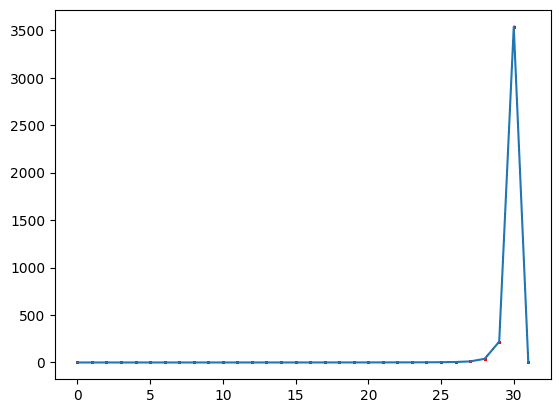

In [63]:
icorr = 0

times = np.arange(tvals)
_  = plt.errorbar(times,jack_mean[icorr,:].real,yerr=jack_std_re[0,:])

for iconf in range (nconf):
    _= plt.plot(times,correlators_navg[iconf,icorr,:].real,'-o',markersize=1,linewidth=0.2,alpha=0.4,color="red")

<ErrorbarContainer object of 3 artists>

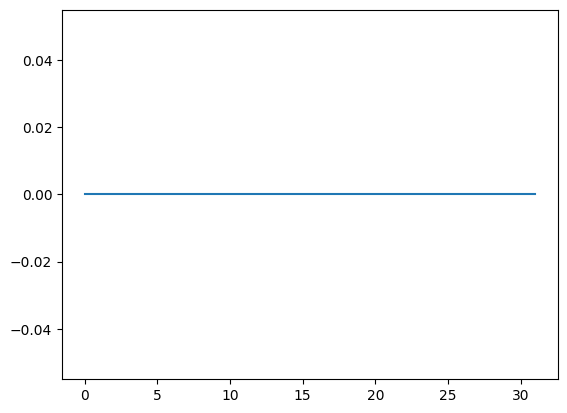

In [51]:
times = np.arange(tvals)
plt.errorbar(times,jack_mean[0,:].imag,yerr=jack_std_im[0,:])

# Jackknife with astropy

In [11]:
#noise average
correlators_navg = np.mean(correlators,axis=-1)

if verbose:
    print("(nconf,ncorr,tvals)")
    print(np.shape(correlators_navg))

(nconf,ncorr,tvals)
(200, 3, 32)


In [14]:
#computation of jacknife mean and related std
test_statistic = np.mean

mean_array = np.empty(shape=(ncorr,tvals),dtype=float)
bias_array = np.empty(shape=(ncorr,tvals),dtype=float)
std_array = np.empty(shape=(ncorr,tvals),dtype=float)
conf_interval_array = np.empty(shape=(ncorr,tvals,2),dtype=float)

for icorr in range(ncorr):
    for t in range(tvals):
        data = correlators_navg[:,icorr,t].real
            
        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
        mean_array[icorr,t] = estimate
        bias_array[icorr,t] = bias
        std_array[icorr,t] = stderr
        conf_interval_array[icorr,t] = conf_interval

In [19]:
std_array/np.abs(mean_array)

np.mean( (std_array/np.abs(mean_array))[:,1:-2] )

/tmp/ipykernel_28695/1064221381.py:1: RuntimeWarning: invalid value encountered in divide
  std_array/np.abs(mean_array)


array([[           nan, 2.79675207e-03, 2.79675128e-03, 2.79674976e-03,
        2.79674702e-03, 2.79674218e-03, 2.79673361e-03, 2.79671848e-03,
        2.79669177e-03, 2.79664459e-03, 2.79656122e-03, 2.79641382e-03,
        2.79615301e-03, 2.79569104e-03, 2.79487166e-03, 2.79341588e-03,
        2.79082387e-03, 2.78619699e-03, 2.77791362e-03, 2.76304002e-03,
        2.73627154e-03, 2.68809505e-03, 2.60187566e-03, 2.45029375e-03,
        2.19474882e-03, 1.79935750e-03, 1.27593237e-03, 7.36337473e-04,
        3.41794694e-04, 1.39798577e-04, 2.87219441e-05,            nan],
       [           nan, 2.81771480e-03, 2.81771416e-03, 2.81771292e-03,
        2.81771070e-03, 2.81770676e-03, 2.81769979e-03, 2.81768750e-03,
        2.81766580e-03, 2.81762747e-03, 2.81755976e-03, 2.81744010e-03,
        2.81722847e-03, 2.81685387e-03, 2.81619000e-03, 2.81501180e-03,
        2.81291694e-03, 2.80918399e-03, 2.80251513e-03, 2.79056977e-03,
        2.76912624e-03, 2.73061347e-03, 2.66170438e-03, 2.54000

/tmp/ipykernel_28695/1064221381.py:3: RuntimeWarning: invalid value encountered in divide
  np.mean( (std_array/np.abs(mean_array))[:,1:-2] )


0.002319652381425569

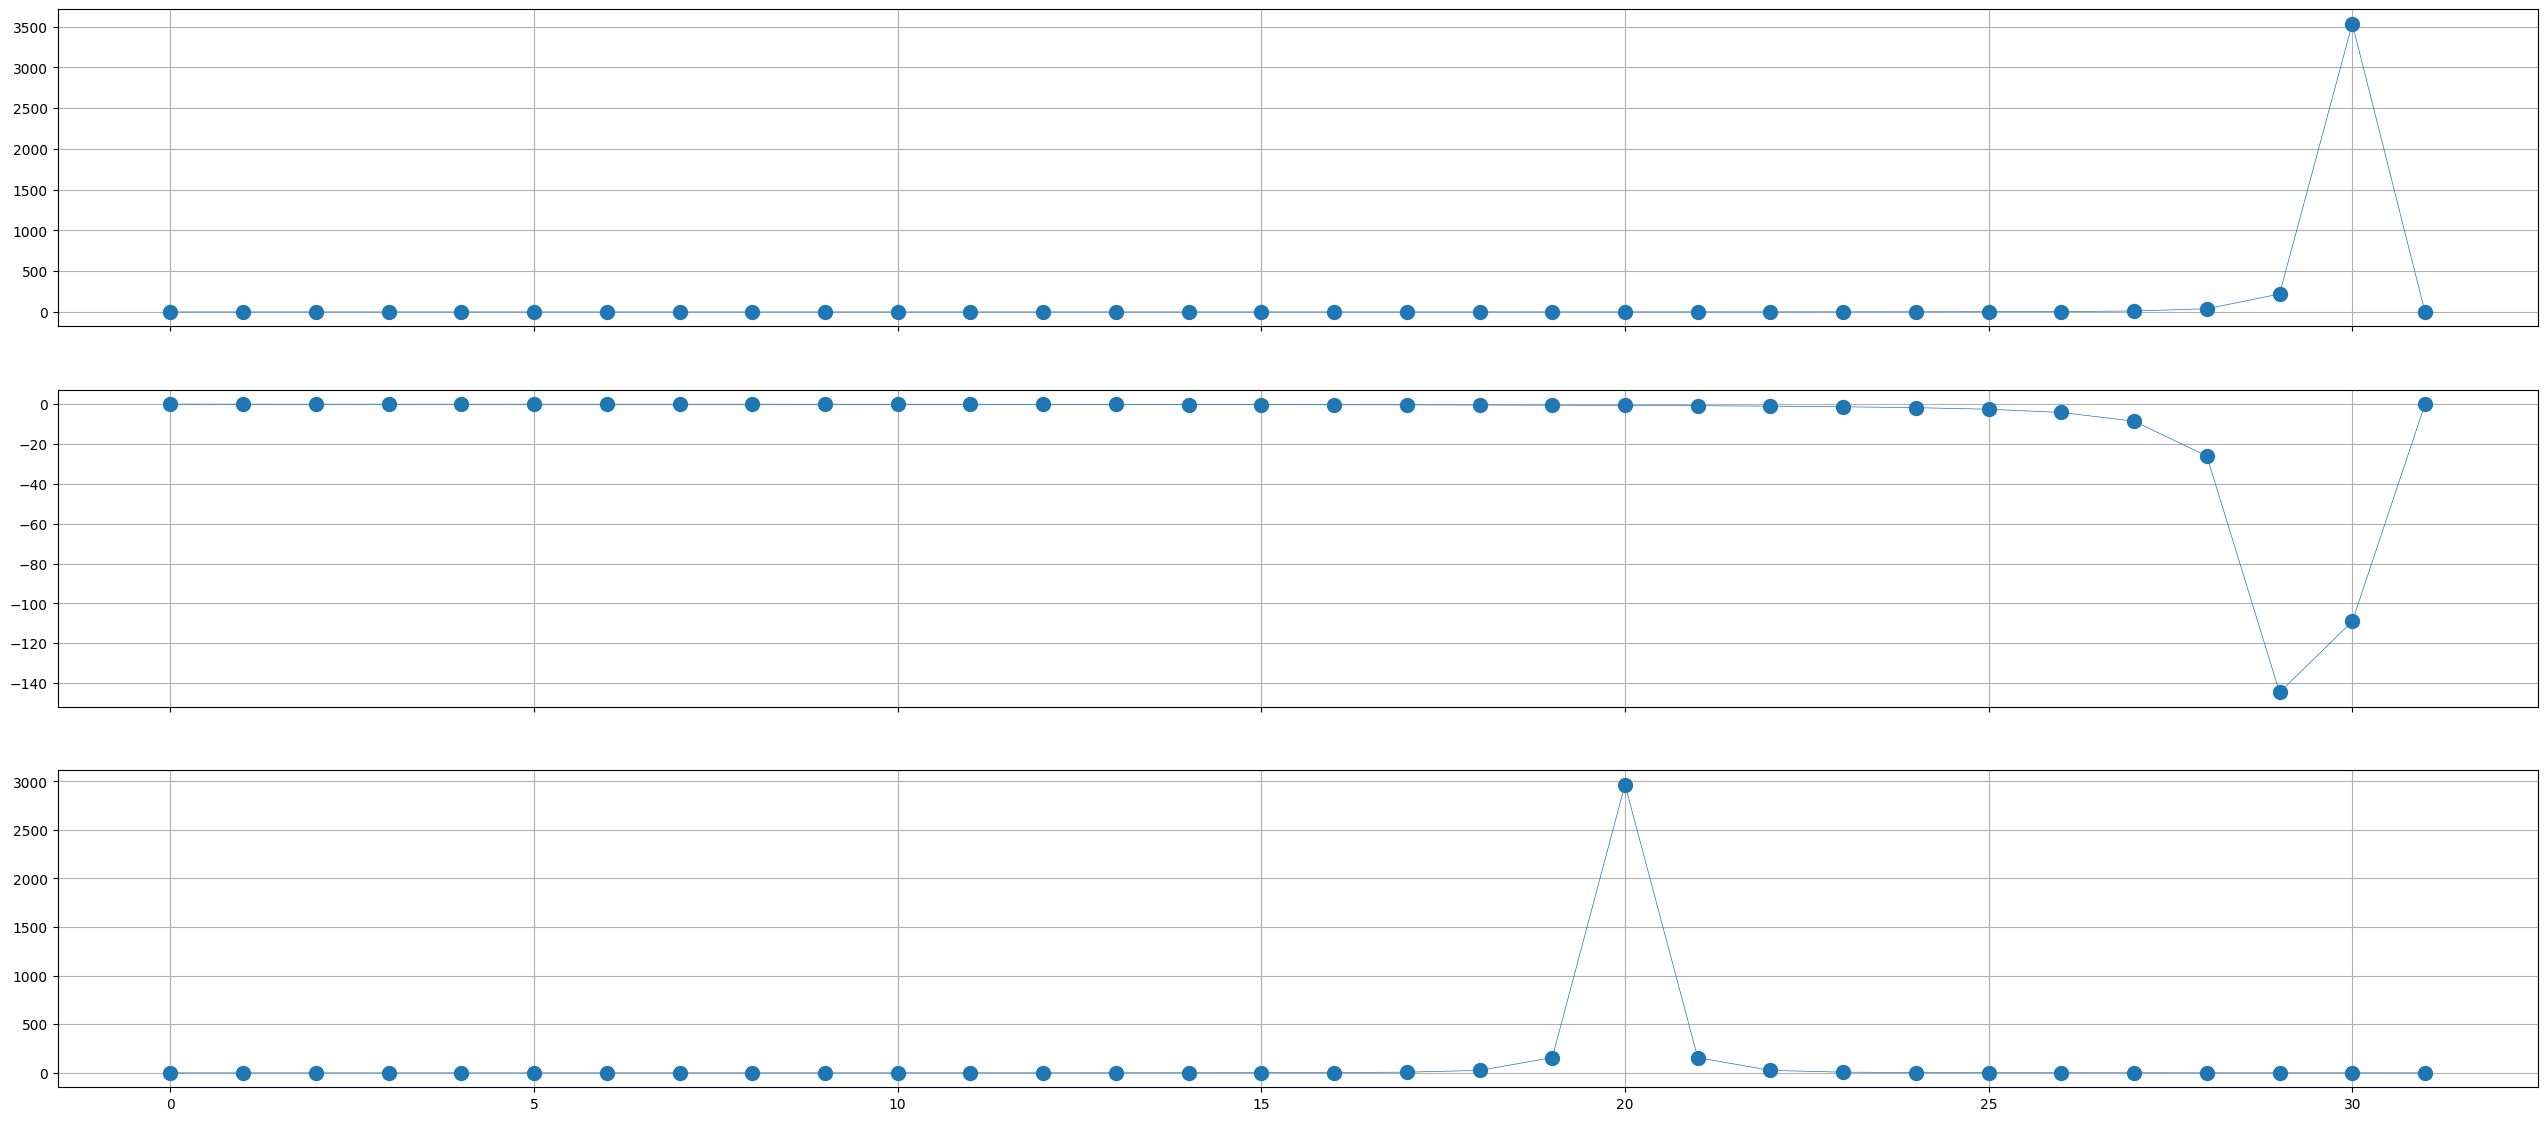

In [18]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=ncorr, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for icorr in range(ncorr):
    _ = ax_list[icorr].errorbar(times,mean_array[icorr,:],yerr=std_array[icorr,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    ax_list[icorr].grid()